In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()

True

In [3]:
train_transform = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor(),
    ])

In [4]:
root = '../chest_xray/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=val_transform)

torch.manual_seed(42)
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, 10, shuffle=False)
val_loader = DataLoader(val_data, batch_size=int(len(val_data)/10), shuffle=False)

train_loader.pin_memory = True
test_loader.pin_memory = True
val_loader.pin_memory = True

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'testing images available:  {len(test_data)}')
print(f'Validation images available:  {len(val_data)}')

['NORMAL', 'PNEUMONIA']
Training images available: 5012
testing images available:  624
Validation images available:  222


In [18]:
put = 150
c1 = put-2
p1 = math.floor(c1/2)
c2 = p1 - 2
p2 = math.floor(c2/2)
c3 = p2 - 2
p3 = math.floor(c3/2)
p3

17

In [6]:
class Model(nn.Module):
    def __init__(self, out_size = 2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
#             nn.Dropout(),
            nn.Linear(17*17*64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(.5),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 17*17*64)
        x = self.classifier(x)
        return F.log_softmax(x, 1)

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [21]:
model = Model().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
train_correct = []
val_losses = []
val_correct = []
min_loss = 100

In [22]:
import time


start_time = time.time()

epochs = 100

# max_trn_batch = 10
# max_val_batch = 2



for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        # Limit the number of batches
#         if b == max_trn_batch:
#             break
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b % (2000/batch_size) == 1 or b == (int(5012/batch_size)):
            print(f'epoch: {i:2}  batch: {b:4} [{batch_size*b:6}/5012]  loss: {loss.item():10.8f}  \
                    accuracy: {trn_corr.item()*100/(batch_size*b):7.3f}%')

    torch.cuda.empty_cache()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the valing batches
    with torch.no_grad():
        loss = 0
        for b, (X_val, y_val) in enumerate(val_loader):
            # Limit the number of batches
            X_val, y_val = X_val.to(device), y_val.to(device)
#             if b == max_tst_batch:
#                 break

            # Apply the model
            y_pred = model(X_val)
            loss += criterion(y_pred, y_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()

    print(f'Validation set: loss: {loss.item():10.8f}  \
                    accuracy: {tst_corr.item()*100/(222):7.3f}%')
    if loss < min_loss:
        torch.save(model.state_dict(), f'customModel3Epoch{i}.pt')
        min_loss = loss
    val_losses.append(loss)
    val_correct.append(tst_corr)
    torch.cuda.empty_cache()

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:    1 [    10/5012]  loss: 0.67340821                      accuracy: 100.000%
epoch:  0  batch:  201 [  2010/5012]  loss: 0.07194356                      accuracy:  81.891%
epoch:  0  batch:  401 [  4010/5012]  loss: 0.27241585                      accuracy:  86.733%
epoch:  0  batch:  501 [  5010/5012]  loss: 1.05327272                      accuracy:  87.864%
Validation set: loss: 3.54760170                      accuracy:  88.739%
epoch:  1  batch:    1 [    10/5012]  loss: 0.00594055                      accuracy: 100.000%
epoch:  1  batch:  201 [  2010/5012]  loss: 0.07692178                      accuracy:  93.781%
epoch:  1  batch:  401 [  4010/5012]  loss: 0.32937962                      accuracy:  93.666%
epoch:  1  batch:  501 [  5010/5012]  loss: 0.08498596                      accuracy:  93.653%
Validation set: loss: 3.44057441                      accuracy:  89.189%
epoch:  2  batch:    1 [    10/5012]  loss: 0.01814532                      accuracy: 100.000%

KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(), f'current.pt')

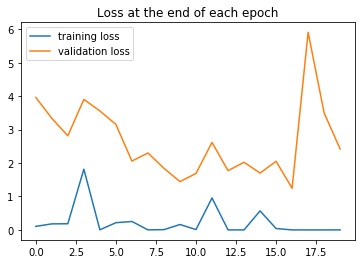

In [23]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [23]:
with torch.no_grad():
    tst_corr = 0
    for (X_test, y_test) in (test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)
        predicted = ((y_pred > .5)).type(torch.int64)
        tst_corr += (predicted == y_test).sum()
        break

In [23]:
y_pred

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [23]:
with torch.no_grad():
    tst_corr = 0
    for b, (X_test, y_test) in enumerate(test_loader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)
        predicted = torch.max(y_pred.data, 1)[1] 
        tst_corr += (predicted == y_test).sum()


In [24]:
tst_corr.item()/624*100

75.64102564102564

In [7]:
model2 = Model().cuda()
model2.load_state_dict(torch.load('customModel3Epoch7.pt'))
model2.eval()

Model(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=18496, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [8]:
with torch.no_grad():
    tst_corr = 0
    for b, (X_test, y_test) in enumerate(test_loader):
        
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model2(X_test)
        predicted = torch.max(y_pred.data, 1)[1] 
        tst_corr += (predicted == y_test).sum()
print(tst_corr.item()/624*100)

75.96153846153845


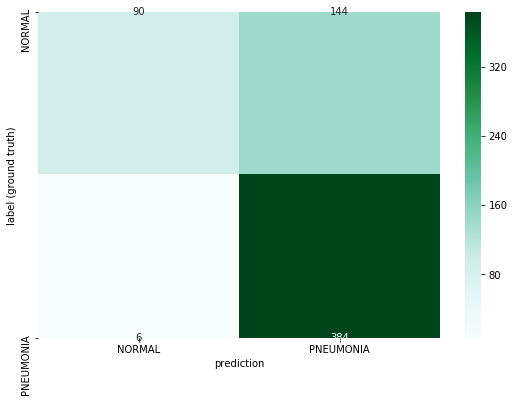

In [16]:
test_load_all = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()


arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();